
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Bootstrap for Subsurface Data Analytics in Python 

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Bootstrap

Uncertainty in the sample statistics
* one source of uncertainty is the paucity of data.
* do 200 or even less wells provide a precise (and accurate estimate) of the mean? standard deviation? skew? P13?

Would it be useful to know the uncertainty in these statistics due to limited sampling?
* what is the impact of uncertainty in the mean porosity e.g. 20%+/-2%?

**Bootstrap** is a method to assess the uncertainty in a sample statistic by repeated random sampling with replacement.

Assumptions
* sufficient, representative sampling, identical, idependent samples

Limitations
1. assumes the samples are representative 
2. assumes stationarity
3. only accounts for uncertainty due to too few samples, e.g. no uncertainty due to changes away from data
4. does not account for boundary of area of interest 
5. assumes the samples are independent
6. does not account for other local information sources

The Bootstrap Approach (Efron, 1982)

Statistical resampling procedure to calculate uncertainty in a calculated statistic from the data itself.
* Does this work?  Prove it to yourself, for uncertainty in the mean solution is standard error: 

\begin{equation}
\sigma^2_\overline{x} = \frac{\sigma^2_s}{n}
\end{equation}

Extremely powerful - could calculate uncertainty in any statistic!  e.g. P13, skew etc.
* Would not be possible access general uncertainty in any statistic without bootstrap.
* Advanced forms account for spatial information and sampling strategy (game theory and Journel’s spatial bootstrap (1993).

Steps: 

1. assemble a sample set, must be representative, reasonable to assume independence between samples

2. optional: build a cumulative distribution function (CDF)
    * may account for declustering weights, tail extrapolation
    * could use analogous data to support

3. For $\ell = 1, \ldots, L$ realizations, do the following:

    * For $i = \alpha, \ldots, n$ data, do the following:

        * Draw a random sample with replacement from the sample set or Monte Carlo simulate from the CDF (if available). 

6. Calculate a realization of the sammary statistic of interest from the $n$ samples, e.g. $m^\ell$, $\sigma^2_{\ell}$. Return to 3 for another realization.

7. Compile and summarize the $L$ realizations of the statistic of interest.

This is a very powerful method.  Let's try it out.

#### Objective 

I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trig etc.
import scipy.signal as signal             # kernel for moving window calculation
import random

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [4]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_biased.csv') # load our data form my GitHub account
#df = pd.read_csv('sample_data_biased.csv') # load our data table locally

Let's drop some samples so that we increase the variations in bootstrap samples for our demonstration below.

In [5]:
df = df.sample(frac = 0.2)                  # extract 50 random samples to reduce the size of the dataset   
print('Using ' + str(len(df)) + ' number of samples')

Using 58 number of samples


Visualizing the DataFrame would be useful and we already learned about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [6]:
#print(df.iloc[0:5,:])                   # display first 4 samples in the table as a preview
df.head(n=13)                           # we could also use this command for a table preview

,X,Y,Facies,Porosity,Perm
44,390,904,1,0.196565,526.891143
133,250,569,1,0.120868,22.277121
46,410,904,1,0.220049,1906.662897
190,930,299,1,0.128736,18.062762
239,550,979,1,0.152277,71.454424
4,100,100,0,0.113049,10.886001
93,300,199,1,0.122520,4.650247
192,420,39,1,0.105300,2.087908
104,740,439,1,0.138149,57.628767
11,300,700,1,0.154220,179.491695


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 0 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,58.0,440.689655,253.922644,20.000000,220.000000,420.000000,607.500000,950.000000
Y,58.0,516.758621,305.973242,29.000000,256.500000,524.500000,809.000000,979.000000
Facies,58.0,0.758621,0.431657,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,58.0,0.132280,0.038060,0.074349,0.103474,0.125964,0.153943,0.220049
Perm,58.0,171.145190,419.474685,0.093252,2.872073,16.982876,59.360818,1906.662897


#### Visualizing Tabular Data with Location Maps 

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.25;           # range of porosity values
nx = 100; ny = 100; csize = 10.0
cmap = plt.cm.inferno                   # color map

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

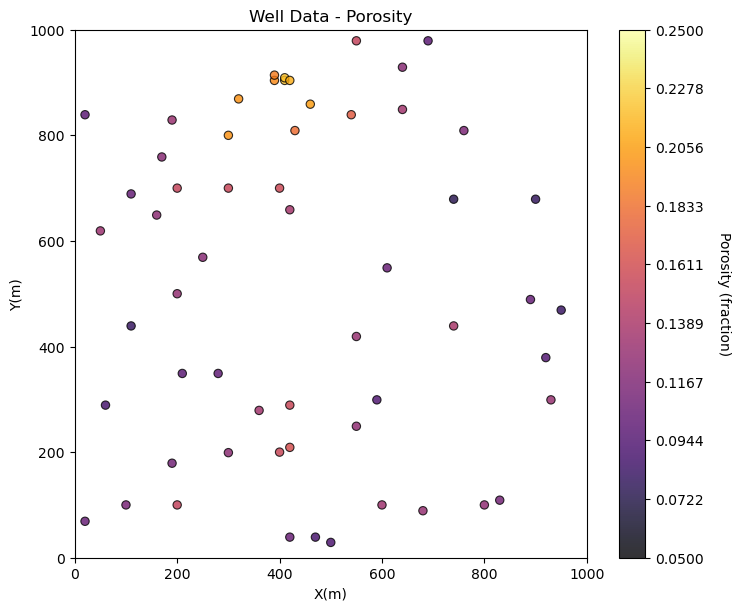

In [10]:
plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

#### A Very Simple Bootstrap Method in Python                       

If you are new to bootstrap and Python, here's the most simple code possible for bootstrap.

* specify the number of bootstrap realizations, $L$
* declare a list to store the bootstrap realizations of the statistic of interest
* loop over L bootstrap realizations
    * n MCS, random samples with replacement for a new realization of the data
    * calculate the realization of the statistic from the realization of the data
* summarize the resulting uncertainty model, histogram, summary statistics etc.

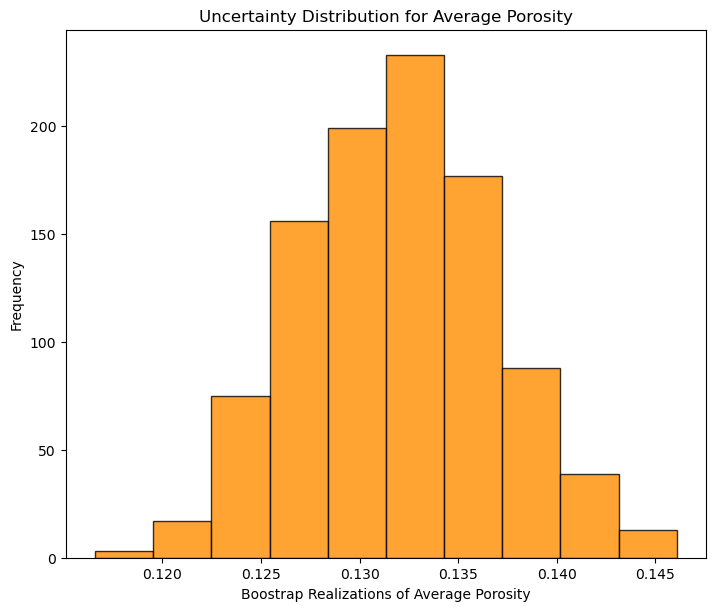

In [11]:
import random                          # import random package
L = 1000                               # set the number of bootstrap realizations   
por_avg_real = []                      # declare an empty list to store the bootstrap realizations of the statistic 
for k in range(0,L):                   # loop over the L bootstrap realizations
    samples = random.choices(df['Porosity'].values, k=len(df)) # n Monte Carlo simulations
    por_avg_real.append(np.average(samples)) # calculate the statistic of interest from the new bootstrap dataset
plt.hist(por_avg_real,color = 'darkorange',alpha = 0.8,edgecolor = 'black') # plot the distribution, could also calculate any summary statistics
plt.xlabel('Boostrap Realizations of Average Porosity'); plt.ylabel('Frequency'); plt.title('Uncertainty Distribution for Average Porosity')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Now we proceed with a more complicated, robust work by first quantifying the spatial bias in the samples and assigned data weights to mitigate this bias.

#### Declustering

Let's calculate some declustering weights. There is a demonstration on declustering here https://git.io/fhgJl if you need more information. 

In [12]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

def weighted_avg_and_std(values, weights): # function to calculate weighted mean and st. dev., from Eric O Lebigot, stack overflow,
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

sample_avg, sample_stdev = weighted_avg_and_std(df['Porosity'],df['Wts'])
print('Declustered mean = ' + str(round(sample_avg,3)) + ' and declustered standard deviation = ' + str(round(sample_stdev,3)))

There are 58 data with:
   mean of      0.1322802637413793 
   min and max  0.074348923 and 0.220049213
   standard dev 0.03773031581137854 
Declustered mean = 0.121 and declustered standard deviation = 0.032


##### A Couple of Bootstrap Realizations

We will attempt boostrap by-hand and manually loop over $L$ realizations and draw $n$ samples to calculate the summary statistics of interest, mean and variance. The choice function from the random package simplifies sampling with replacement from a set of samples with weights.

This command returns a ndarray with k samples with replacment from the 'Porosity' column of our DataFrame (df) accounting for the data weights in column 'Wts'.
```p
samples1 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
```

It is instructive to look at a couple of these realizations from the original declustered data set.

Bootstrap means, realization 1 = 0.13015553572413793 and realization 2 = 0.12685247082758622


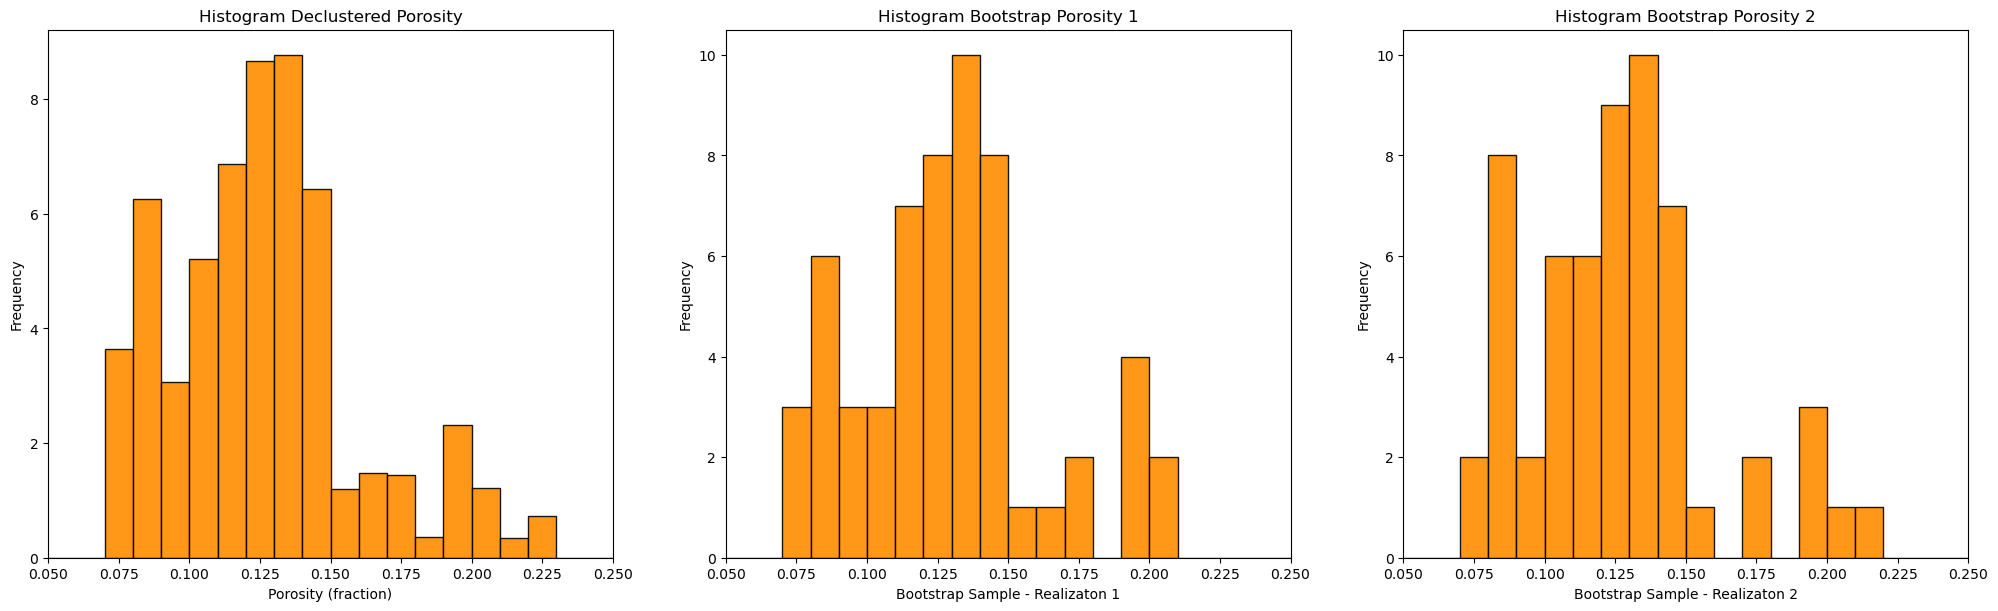

In [14]:
samples1 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
samples2 = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))

print('Bootstrap means, realization 1 = ' + str(np.average(samples1)) + ' and realization 2 = ' + str(np.average(samples2)))

plt.subplot(131)
GSLIB.hist_st(df['Porosity'],pormin,pormax,False,False,20,df['Wts'],'Porosity (fraction)','Histogram Declustered Porosity')

plt.subplot(132)
GSLIB.hist_st(samples1,pormin,pormax,False,False,20,None,'Bootstrap Sample - Realizaton 1','Histogram Bootstrap Porosity 1')

plt.subplot(133)
GSLIB.hist_st(samples2,pormin,pormax,False,False,20,None,'Bootstrap Sample - Realizaton 2','Histogram Bootstrap Porosity 2')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

Note that the bootstrap distributions vary quite a bit from the original.

#### Summarizations Over Bootstrap Realizations

Let's make a loop to conduct $L$ resamples and calculate the average and standard deviation for each  ($m^\ell$, $\sigma^2_{\ell}$,  for $\ell = 0,\dots,L-1$). We then summarization over these $L$ realizations.  

I did not find any built-in, concise functions to accomplish this, i.e. with a single line of code, so we are going to do it by hand.  

To understand this code there are just a couple of Python concepts that you need to add to your Python arsenal.

1. declaring arrays - NumPy has a lot of great array (ndarray) functionality. There are build in functions to make a ndarray of any length (and dimension). This includes 'zeros', 'ones' and 'rand', so when we use this code:

```p
mean = np.zeros(L); stdev = np.zeros(L)
```

    we're making arrays of length $L$ pre-populated with zeros.

2. For Loops - when we are using the command below, we are instructing the computer to loop over all the indented code below the command for $l = 0,1,2,\ldots,L-1$ times. For each loop the $l$ variable increments, so we can use this to save each result to a different index in the arrays mean and stdev. Note, Python arrays index starting at 0 and stop at the length - 1.

```p
for l in range(0, L): 
```

    we are running each bootstrap resampled realization, calculating the average and standard deviation and storing them in the arrays that we already declared.

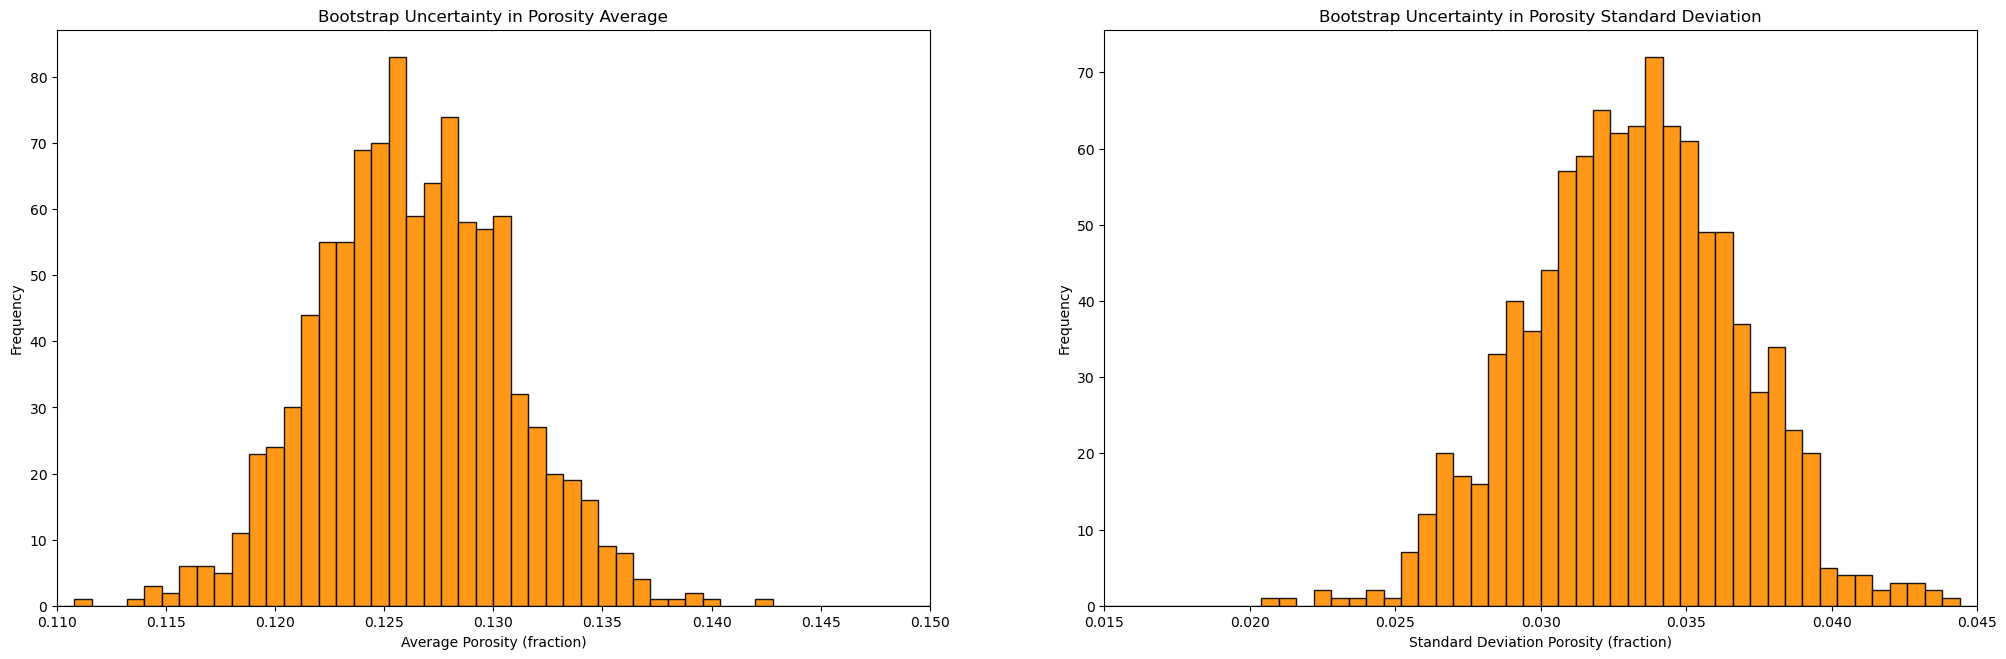

Summary Statistics for Bootstrap Porosity Mean Realizations:
DescribeResult(nobs=1000, minmax=(0.11122572567241379, 0.1420599749310345), mean=0.12632053895853448, variance=1.896122619525374e-05, skewness=0.06876393598441356, kurtosis=0.11518904196585478)
P10: 0.121, P50: 0.126, P90: 0.132

Summary Statistics for Bootstrap Porosity Standard Deviation Realizations:
DescribeResult(nobs=1000, minmax=(0.020521103273504065, 0.0439498040963041), mean=0.03315232602569918, variance=1.2756279283165868e-05, skewness=-0.07571175229104361, kurtosis=0.03081967278541642)
P10: 0.029, P50: 0.033, P90: 0.038


In [15]:
L = 1000                                   # set the number of realizations
mean = np.zeros(L); stdev = np.zeros(L)    # declare arrays to hold the realizations of the statistics
for l in range(0, L):                      # loop over realizations
    samples = random.choices(df['Porosity'].values, weights=df['Wts'].values, cum_weights=None, k=len(df))
    mean[l] = np.average(samples)
    stdev[l] = np.std(samples)
    
plt.subplot(121)
GSLIB.hist_st(mean,0.11,0.15,False,False,50,None,'Average Porosity (fraction)','Bootstrap Uncertainty in Porosity Average')

plt.subplot(122)
GSLIB.hist_st(stdev,0.015,0.045,False,False,50,None,'Standard Deviation Porosity (fraction)','Bootstrap Uncertainty in Porosity Standard Deviation')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()   
    
print('Summary Statistics for Bootstrap Porosity Mean Realizations:')
print(stats.describe(mean))
print('P10: ' + str(round(np.percentile(mean,10),3)) + ', P50: ' + str(round(np.percentile(mean,50),3)) + ', P90: ' + str(round(np.percentile(mean,90),3))) 

print('\nSummary Statistics for Bootstrap Porosity Standard Deviation Realizations:')
print(stats.describe(stdev))
print('P10: ' + str(round(np.percentile(stdev,10),3)) + ', P50: ' + str(round(np.percentile(stdev,50),3)) + ', P90: ' + str(round(np.percentile(stdev,90),3))) 


#### Comments

This was a basic demonstration of bootstrap. Much more could be done, you could replace the statistics, average and standard deviation with any other statistics, for example P90, kurtosis, P13 etc. I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
